In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import numpy as np
import contextlib
import sys

In [2]:
# Suppress the progress bar
with contextlib.redirect_stdout(sys.stderr):
    # Fetch the data for the maximum available period
    ticker = "AAPL"
    aapl_data = yf.download(ticker, period='max', interval='1d', progress=False)

In [3]:
# Filter the data for the desired periods
train_data = aapl_data.loc[(aapl_data.index >= '2004-01-01') & (aapl_data.index <= '2018-12-31')].copy()
test_data = aapl_data.loc[(aapl_data.index >= '2019-01-01') & (aapl_data.index <= '2023-12-31')].copy()

# Calculate monthly percentage change in Close price for training data
train_data['Month'] = train_data.index.to_period('M')
monthly_close_train = train_data['Close'].resample('M').last()
monthly_pct_change_train = monthly_close_train.pct_change() * 100

# Create a pivot table for the heat map (training data)
monthly_pct_change_train_df = monthly_pct_change_train.to_frame(name='Monthly Return')
monthly_pct_change_train_df['Year'] = monthly_pct_change_train_df.index.year
monthly_pct_change_train_df['Month'] = monthly_pct_change_train_df.index.month

pivot_table_train = monthly_pct_change_train_df.pivot_table(values='Monthly Return', index='Year', columns='Month')

# Debugging: Print the pivot table for training data
print("Training data pivot table:\n", pivot_table_train.head(3))

Training data pivot table:
 Month         1          2          3          4          5          6   \
Year                                                                      
2004         NaN   6.028442  13.043402  -4.659760   8.843998  15.965811   
2005   19.409916  16.671039  -7.111040 -13.462913  10.260681  -7.419502   
2006    5.035474  -9.296808  -8.424568  12.228968 -15.087372  -4.182717   

Month         7         8          9          10         11        12  
Year                                                                   
2004   -0.614561  6.648142  12.351328  35.225828  27.958014 -3.952247  
2005   15.865216  9.941417  14.331413   7.423995  17.763487  6.001179  
2006   18.665989 -0.161883  13.456178   5.326041  13.048836 -7.440530  


Positive counts for each month in training data:
 Month
1      8
2      9
3     10
4      9
5     11
6      5
7     12
8     11
9      8
10    12
11     8
12     7
dtype: int64
Identified months with positive returns for at least 12 out of 15 years in training data:
 ['Jul', 'Oct']


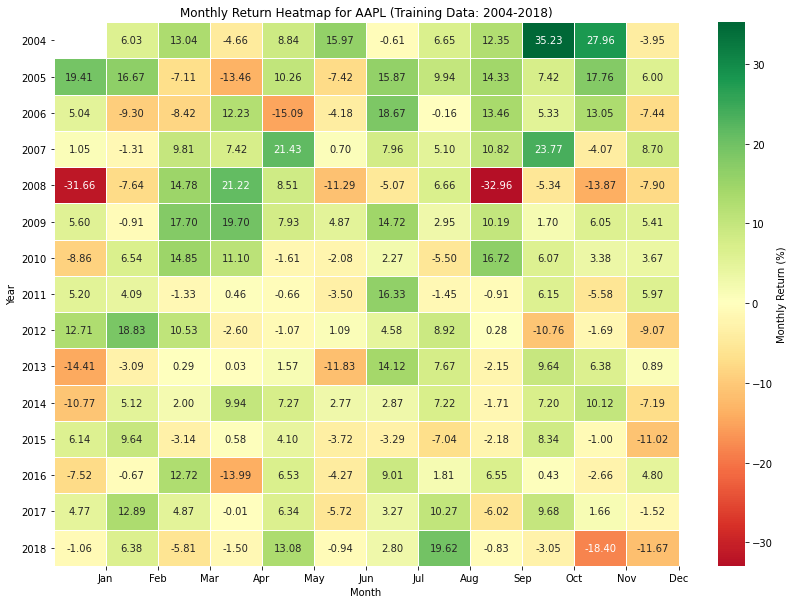

In [4]:
# Identify months with positive returns for at least 12 out of 15 years in training data
positive_counts_train = (pivot_table_train > 0).sum()
print("Positive counts for each month in training data:\n", positive_counts_train)
positive_months_train = positive_counts_train[positive_counts_train >= 12].index

# Debugging: Print identified positive months in training data
print("Identified months with positive returns for at least 12 out of 15 years in training data:\n", [calendar.month_abbr[m] for m in positive_months_train])

# Plotting the heat map for training data
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table_train.loc[2004:2018], cmap='RdYlGn', annot=True, fmt=".2f", linewidths=.5, center=0, cbar_kws={'label': 'Monthly Return (%)'})
plt.xticks(ticks=range(1, 13), labels=[calendar.month_abbr[i] for i in range(1, 13)], rotation=0)
plt.yticks(rotation=0)
plt.title('Monthly Return Heatmap for AAPL (Training Data: 2004-2018)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

In [5]:
# Calculate monthly percentage change in Close price for testing data
test_data['Month'] = test_data.index.to_period('M')
monthly_close_test = test_data['Close'].resample('M').last()
monthly_pct_change_test = monthly_close_test.pct_change() * 100

# Create a pivot table for the heat map (testing data)
monthly_pct_change_test_df = monthly_pct_change_test.to_frame(name='Monthly Return')
monthly_pct_change_test_df['Year'] = monthly_pct_change_test_df.index.year
monthly_pct_change_test_df['Month'] = monthly_pct_change_test_df.index.month

pivot_table_test = monthly_pct_change_test_df.pivot_table(values='Monthly Return', index='Year', columns='Month')

# Calculate the success rate for identified months in the test data
success_rates = {}
for month in positive_months_train:
    positive_count_test = (pivot_table_test[month] > 0).sum()
    total_count_test = pivot_table_test[month].count()
    success_rate = (positive_count_test / total_count_test) * 100
    success_rates[month] = success_rate

# Calculate overall success rate
overall_positive_count_test = (pivot_table_test[positive_months_train] > 0).sum().sum()
overall_total_count_test = pivot_table_test[positive_months_train].count().sum()
overall_success_rate = (overall_positive_count_test / overall_total_count_test) * 100

# Print results
print("Success rates in test data for identified months:")
for month, rate in success_rates.items():
    print(f"{calendar.month_abbr[month]}: {rate:.2f}%")

print(f"Overall success rate: {overall_success_rate:.2f}%")

Success rates in test data for identified months:
Jul: 100.00%
Oct: 60.00%
Overall success rate: 80.00%


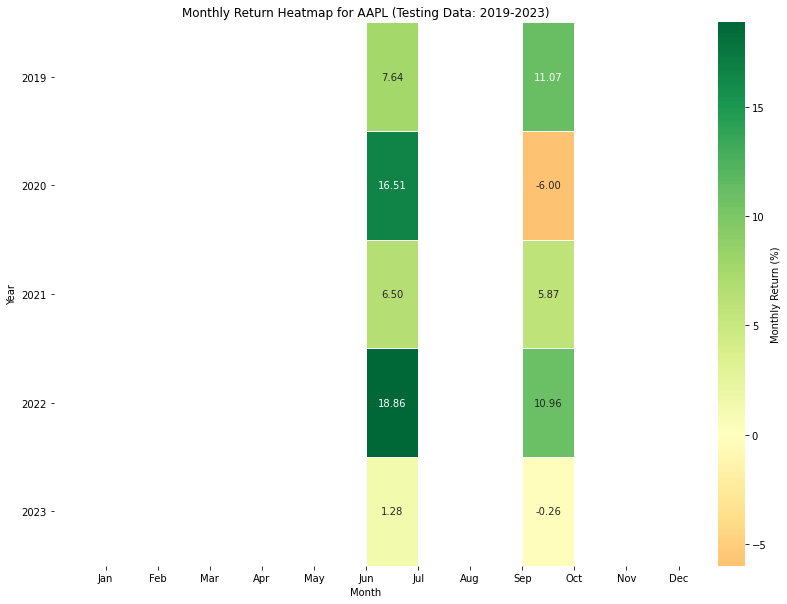

In [6]:
# Create a heatmap for the test data but only for the identified positive months
plt.figure(figsize=(14, 10))
# Create a DataFrame for plotting, filling non-selected months with NaN
heatmap_data = pivot_table_test.loc[2019:2023].copy()
for month in range(1, 13):
    if month not in positive_months_train:
        heatmap_data[month] = np.nan  # Set non-identified months to NaN

sns.heatmap(heatmap_data, cmap='RdYlGn', annot=True, fmt=".2f", linewidths=.5, center=0, cbar_kws={'label': 'Monthly Return (%)'}, mask=heatmap_data.isnull())

plt.xticks(ticks=range(1, 13), labels=[calendar.month_abbr[i] for i in range(1, 13)], rotation=0)
plt.yticks(rotation=0)
plt.title('Monthly Return Heatmap for AAPL (Testing Data: 2019-2023)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()